In [1]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from arcos4py.tools import detectCollev
from napari import Viewer

In [3]:
filepath = "C:/Users/benig/Documents/python_dev/segmentatoin_degradatoin/example_data/mdck_ekar/041_Ori.tif"
img = io.imread(filepath)[:,:,:,0]

c:\Users\benig\miniconda3\envs\arcos4py_dev\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


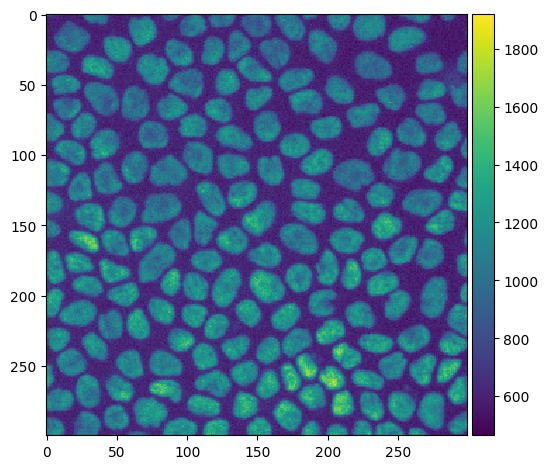

In [4]:
io.imshow(img[0])

In [14]:
bin_img = np.where(img >900, 1, 0)[0:50]

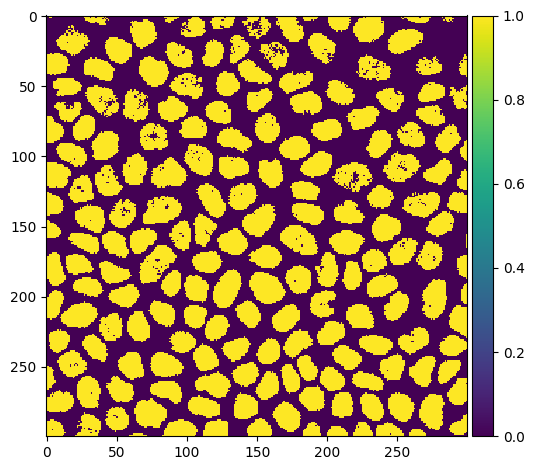

In [6]:
io.imshow(bin_img[4])

In [12]:
ts = detectCollev(bin_img, eps=1.1, minClSz=5, posCols=['x', 'y'], frame_column='t', id_column='track_id', bin_meas_column="value", n_jobs=-1)
df_out = ts.run()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Frame 1.0
Frame 2.0
Frame 3.0
Frame 4.0


In [13]:
# viewer = Viewer()
viewer.add_image(df_out, name='binary image')

<Image layer 'binary image [1]' at 0x22521ab3fd0>

In [ ]:
def _image_to_dataframe(image: np.ndarray, dims: str = "TXY") -> pd.DataFrame:
    """Converts a 2d image series to input that can be accepted by the ARCOS event detection function
    with columns for x, y, and intensity.
    Arguments:
        image (np.ndarray): Image to convert. Assumes first axis is t and the two last axes are y and x.
        dims (str): String of dimensions in order. Default is "TXY". Possible values are "T", "X", "Y", and "Z".
    Returns (tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple of arrays with coordinates, measurements, and frame numbers.
    """
    available_dims = ["T", "X", "Y", "Z"]
    dims_list = list(dims.upper())

    for i in dims_list:
        if i not in dims_list:
            raise ValueError(f"Invalid dimension {i}. Must be 'T', 'X', 'Y', or 'Z'.")
        
    if len(dims_list) > len(set(dims_list)):
        raise ValueError(f"Duplicate dimensions in dims.")
        
    if len(dims_list) != image.ndim:
        raise ValueError(f"Length of dims must be equal to number of dimensions in image. Image has {image.ndim} dimensions.")

    dims_dict = {i: dims_list.index(i) for i in available_dims if i in dims_list}
    coordinates_in_image = len([i for i in dims_list if i != "T"])

    output_shape = 1
    for i in range(image.ndim):
        output_shape *= image.shape[i]

    if dims_dict["T"] != 0:
        image_reshaped = np.moveaxis(image, dims_dict["T"], 0)
    else:
        image_reshaped = image
    
    coordinates_array_out = np.zeros((output_shape, coordinates_in_image))
    meas_array_out = np.zeros((output_shape,))
    frame_array_out = np.zeros((output_shape,))

    for idx, i in enumerate(image_reshaped):
        coordinates_array = np.moveaxis(np.indices(i.shape), 0, coordinates_in_image).reshape((-1, coordinates_in_image))
        meas_array = i.flatten()
        frame_array = np.repeat(idx, coordinates_array.shape[0])
        
        coordinates_array_out[idx*image.shape[1]*image.shape[2]:(idx+1)*image.shape[1]*image.shape[2],:] = coordinates_array
        meas_array_out[idx*image.shape[1]*image.shape[2]:(idx+1)*image.shape[1]*image.shape[2],] = meas_array
        frame_array_out[idx*image.shape[1]*image.shape[2]:(idx+1)*image.shape[1]*image.shape[2],] = frame_array

    return coordinates_array_out, meas_array_out, frame_array_out

def _2d_image_to_dataframe(image: np.ndarray, thresh: int = 0) -> pd.DataFrame:
    """Converts a 2d image series to a dataframe with columns for x, y, and intensity.
    to be used with ARCOS.
    Arguments:
        image (np.ndarray): Image to convert. Assumes first axis is t and the two last axes are y and x.
        thresh (int): Threshold to use to remove background. Default is 0.
    Returns (pd.DataFrame): Dataframe with image data.
    """
    df_all = []
    for idx, i in enumerate(image):
        indicesArray = np.moveaxis(np.indices(i.shape), 0, 2)
        allArray = np.dstack((indicesArray, i)).reshape((-1, 3))
        df = pd.DataFrame(allArray, columns=["y", "x", "value"])
        df_all.append(df)
        df['t'] = idx
    df_all_combined = pd.concat(df_all)
    df_all_combined['track_id'] = np.tile(
        np.arange(len(df_all_combined[df_all_combined.t == 0])), len(df_all_combined.t.unique())
    )
    df_all_combined = df_all_combined[df_all_combined['value'] > thresh]
    return df_all_combined

def _image_to_arrays(image: np.ndarray, dims: int = 2) -> pd.DataFrame:
    """Converts an image to a flattened array with columns for x, y, and intensity.
    to be used with ARCOS.
    """
    coordinates_array = np.moveaxis(np.indices(image.shape), 0, 2).reshape((-1, 2))
    meas_array = image.flatten()
    frame_array = np.repeat(0, coordinates_array.shape[0])

    return coordinates_array, frame_array, meas_array


def _3d_image_to_dataframe(image: np.ndarray, thresh: int = 0) -> pd.DataFrame:
    """Converts a 3d image series to a dataframe with columns for x, y, z, and intensity.
    to be used with ARCOS.
    Arguments:
        image (np.ndarray): Image to convert. Assumes first axis is t and the three last axes are z, y, and x.
        thresh (int): Threshold to use to remove background. Default is 0.
    Returns (pd.DataFrame): Dataframe with image data.
    """
    df_all = []
    for idx, i in enumerate(image):
        indicesArray = np.moveaxis(np.indices(i.shape), 0, 3)
        allArray = np.dstack((indicesArray, i)).reshape((-1, 4))
        df = pd.DataFrame(allArray, columns=["z", "y", "x", "value"])
        df_all.append(df)
        df['t'] = idx
    df_all_combined = pd.concat(df_all)
    df_all_combined['track_id'] = np.tile(
        np.arange(len(df_all_combined[df_all_combined.t == 0])), len(df_all_combined.t.unique())
    )
    df_all_combined = df_all_combined[df_all_combined['value'] > thresh]
    return df_all_combined


def image_to_dataframe(image: np.ndarray, thresh: int = 0):
    """Converts an image series to a dataframe with columns for x, y, z, and intensity. Assumes axis order (t, y, x) for 2d images and (t, z, y, x) for 3d images.
    Arguments:
        image (np.ndarray): Image to convert. Assumes first axis is t and the three last axes are z, y, and x.
        thresh (int): Threshold to use to remove background. Default is 0.
    Returns (pd.DataFrame): Dataframe with image data.
    """
    if image.ndim == 3:
        return _2d_image_to_dataframe(image, thresh)
    elif image.ndim == 4:
        return _3d_image_to_dataframe(image, thresh)
    else:
        raise ValueError(f'Image must have 3 or 4 dimensions. Image has {image.ndim} dimensions.')

In [ ]:
out = _2d_image_to_dataframe(bin_img, thresh=0)

In [ ]:
ts = detectCollev(out, 5, minClSz=50, posCols=['x', 'y'], frame_column='t', id_column='track_id', bin_meas_column="value")
df_out = ts.run()

In [ ]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# # Definitions and custom functions
# Color Cycle used throughout the plugin for collective events.
# Color values correspond to hex values of the matplotlib tab20
# colorscale
COLOR_CYCLE = [
    "#1f77b4",
    "#aec7e8",
    "#ff7f0e",
    "#ffbb78",
    "#2ca02c",
    "#98df8a",
    "#d62728",
    "#ff9896",
    "#9467bd",
    "#c5b0d5",
    "#8c564b",
    "#c49c94",
    "#e377c2",
    "#f7b6d2",
    "#7f7f7f",
    "#c7c7c7",
    "#bcbd22",
    "#dbdb8d",
    "#17becf",
    "#9edae5",
]
# text parameters for the timestamp
text_parameters = {
    "text": "{label}",
    "size": 12,
    "color": "white",
    "anchor": "center",
    "translation": [0, 0],
}


def make_timestamp(
    viewer,
    start_time=0,
    step_time=1,
    prefix="T =",
    suffix="frame",
    position="upper_left",
    size=12,
    x_shift=12,
    y_shift=0,
):
    """
    Create a timestamp displayed in the viewer.
    This is done by creating a dummy shape layer
    and annotating it with the current time.
    """
    anchors = ["upper_right", "upper_left", "lower_right", "lower_left", "center"]
    if position not in anchors:
        raise ValueError(f'"position" must be one of: {anchors}')

    text_parameters_tmstp = {
        "text": "{label}",
        "size": size,
        "color": "white",
        "anchor": position,
        "translation": [x_shift, y_shift],
    }
    out = {}
    rgt, rgy, rgx = deepcopy(viewer.dims.range)
    # Napari uses float64 for dims
    maxx, maxy, maxt = rgx[1], rgy[1], rgt[1] - 1
    # Points to the corners of the image at each frame
    corners = [
        np.array(
            [
                [t, np.float64(0), np.float64(0)],
                [t, np.float64(0), maxx],
                [t, maxy, maxx],
                [t, maxy, np.float64(0)],
            ]
        )
        for t in np.arange(maxt + 1).astype("float64")
    ]
    out["properties"] = {}
    timestamp = [start_time + step * step_time for step in range(int(maxt + 1))]
    out["properties"]["label"] = [f"{prefix} {str(i)} {suffix}" for i in timestamp]
    out["data"] = corners
    # Fully transparent white because just want the text, not the shape
    out["face_color"] = np.repeat("#ffffff00", len(corners))
    out["edge_color"] = np.repeat("#ffffff00", len(corners))
    out["shape_type"] = "rectangle"
    out["text"] = text_parameters_tmstp
    out["opacity"] = 1
    return out


def calculate_convex_hull(array):
    """Calculates the convex hull for a 2d array of points.

    Parameters:
        array (np.ndarray): A 2d array of points with x and y coordinates.

    Returns (np.ndarray): If shape of input array can be used
    to calculate convex hull the vertices of the convex hull are returned.
    If shape is less, the points themselfs are returned.
    """
    # Todo check if there is a better way to check for coplanar
    # points rathern than using QhullError
    try:
        if array.shape[0] > 2:
            hull = ConvexHull(array[:, 2:])
            array_out = array[hull.vertices]
            return array_out
        if array.shape[0] == 2:
            return array
    except Exception:
        return array


def calculate_convex_hull_3d(array):
    """Calculates the convex hull for a 3d array of points.

    Parameters:
        array (np.ndarray): A 2d array of points with x y and z coordinates.

    Returns (np.ndarray): If shape of input array can be used
    to calculate convex hull the vertices of the convex hull are returned.
    If shape is less, the points themselfs are returned.
    """
    if array.shape[0] > 3:
        hull = ConvexHull(array[:, 2:])
        array_faces = hull.simplices
        if array_faces.shape[0] != 0:
            return array_faces
    if array.shape[0] == 3:
        array_faces = np.array([[0, 1, 2]])
        return array_faces
    if array.shape[0] == 2:
        array_faces = np.array([[0, 1, 1]])
        return array_faces
    if array.shape[0] == 1:
        array_faces = np.array([[0, 0, 0]])
        return array_faces


def get_verticesHull(df, frame, colid, col_x, col_y):
    """Calculate convex hull for 2d collective events.

    Input dataframe is converted into a numpy array and split into groups
    according to unique collective ids.
    For each set array the convex hull is calculated.

    Parameters:
        df (pd.DataFrame): A dataframe with at least 4 columns
        containing the XY coordinates of a set of points aswell
        as frame and collective id columns.
        frame (str): Name of frame column in df.
        colid (str): Name of collective id column in df.
        col_x (str): Name of column x coordinate column in df.
        col_y (str): Name of column y coordinate column in df.

    Returns (np.ndarray,np.ndarray): Tuple containing arrays of vertices,
    one for each collective event. Array of colors, a unique
    one for each collective event.
    """
    df = df.sort_values([colid, frame])
    df[colid], _ = pd.factorize(df[colid])
    df[colid] += 1
    array_txy = df[[colid, frame, col_y, col_x]].to_numpy()
    array_txy = array_txy[~np.isnan(array_txy).any(axis=1)]
    grouped_array = np.split(
        array_txy, np.unique(array_txy[:, 0:2], axis=0, return_index=True)[1][1:]
    )
    # map to grouped_array
    convex_hulls = [calculate_convex_hull(i) for i in grouped_array if i.shape[0] > 1]
    color_ids = np.take(
        np.array(COLOR_CYCLE), [int(i[0, 0]) for i in convex_hulls], mode="wrap"
    )
    # color_ids = recycle_palette(COLOR_CYCLE, len(convex_hulls))
    out = [i[:, 1:] for i in convex_hulls]
    return out, color_ids


# @profile
def make_surface_3d(
    df: pd.DataFrame, frame: str, col_x: str, col_y: str, col_z: str, colid: str
):
    """Calculate convex hull for 3d collective events.

    Input dataframe is converted into a numpy array and split into groups
    according to unique collective ids.
    For each set array the convex hull is calculated.
    A tuple that can be used to add 3d convex hull with the napari
    add_surface function is generated.
    Output has to be appended with empy vertices and surfaces for the
    timepoints where no surface should be drawn. Otherwise will
    result in a nontype subscription error.

    Parameters:
        df (pd.DataFrame): A dataframe with at least 4 columns
        containing the XY coordinates of a set of points aswell
        as frame and collective id columns.
        frame (str): Name of frame column in df.
        colid (str): Name of collective id column in df.
        col_x (str): Name of x coordinate column in df.
        col_y (str): Name of y coordinate column in df.
        col_z (str): Name of z coordinate column in df.

    Returns (tuple(np.ndarray, np.ndarray, np.ndarray)): Tuple that contains
    vertex coordinates, face indices and color ids
    """
    dataFaces = []
    vertices_count = 0
    # sort needed for np.split
    df = df.sort_values([colid, frame])
    array_idtyxz = df[[colid, frame, col_y, col_x, col_z]].to_numpy()
    array_idtyxz = array_idtyxz[~np.isnan(array_idtyxz).any(axis=1)]
    # split array into list of arrays, one for each collid/timepoint combination
    grouped_array = np.split(
        array_idtyxz, np.unique(array_idtyxz[:, 0:2], axis=0, return_index=True)[1][1:]
    )
    # calc convex hull for every array in the list
    convex_hulls = [calculate_convex_hull_3d(i) for i in grouped_array]
    # generates color ids (integers for LUT in napari)
    color_ids = np.concatenate([i[:, 0].astype(np.int64) for i in grouped_array])
    out_vertices = np.concatenate(grouped_array)[:, 1:]
    # merge convex hull face list and shift indexes according to groups
    for i, val in enumerate(convex_hulls):
        dataFaces.append(np.add(val, vertices_count))
        vertices_count += len(grouped_array[i])
    out_faces = np.concatenate(dataFaces)
    return (out_vertices, out_faces, color_ids)


# @profile
def fix_3d_convex_hull(df, vertices, faces, colors, col_t):
    """Generate empty vertex and faces to fix napari subset error.

    Parameters:
        df (pd.DataFrame): A dataframe used to calculate convex hulls.
        vertices (np.ndarray): vertex coordinates.
        faces (np.ndarray): Array containing face indices.
        colors (np.ndarray): Array containing color ids.
        col_t (str): String name of frame column in df.
    """
    empty_vertex = []
    empty_faces = []
    empty_colors = []
    time_points = np.unique(vertices[:, 0])
    arr_size = vertices.shape[0]
    for i in df[col_t].unique():
        if i not in time_points:
            empty_vertex.append([i, 0, 0, 0])
            empty_faces.append([arr_size, arr_size, arr_size])
            arr_size = arr_size + 1
            empty_colors.append(0)

    surface_tuple_0 = np.concatenate((vertices, np.array(empty_vertex)), axis=0)
    surface_tuple_1 = np.concatenate((faces, np.array(empty_faces)), axis=0)
    surface_tuple_2 = np.concatenate((colors, np.array(empty_colors)), axis=0)

    return (surface_tuple_0, surface_tuple_1, surface_tuple_2)


def calc_bbox(array: np.ndarray):
    """Calcualte the bounding box of input array.

    Parameters:
        array (np.ndarray): 2d array of coordinates
        for which to compute the bounding box.

    Returns (np.ndarray): 2d array of coordinates for the bounding box.
    """
    t = array[0, 0]
    pos_array = array[:, 1:]
    # 3d case
    if pos_array.shape[1] == 3:

        miny, minx, minz = np.min(pos_array, axis=0)
        maxy, maxx, maxz = np.max(pos_array, axis=0)
        return np.array(
            [
                [t, miny, minx, minz],
                [t, miny, minx, maxz],
                [t, miny, maxx, maxz],
                [t, miny, maxx, minz],
                [t, maxy, maxx, minz],
                [t, maxy, minx, minz],
                [t, maxy, minx, maxz],
                [t, maxy, maxx, maxz],
            ]
        )
    # 2d case
    miny, minx = np.min(pos_array, axis=0)
    maxy, maxx = np.max(pos_array, axis=0)
    return np.array(
        [[t, miny, minx], [t, miny, maxx], [t, maxy, maxx], [t, maxy, minx]]
    )


def get_bbox(
    df: pd.DataFrame, clid: int, frame: str, xcol: str, ycol: str, edge_size: float = 10
):
    """Get bounding box of dataframe in long format with position columns, for 2d case.

    Parameters:
        df (pd.DataFrame): dataframe to get bounding box form.
        frame (str): Name of frame column.
        xcol (str): X coordinate column.
        ycol (str): Y coordinate column.
        edge_size (float): Bounding Box edge_size, also used to calculate text size.

    Returns (nd.array, dict): Array that can be added to
    napari with add_shapes function aswell
    as dictionary that can be unpacked
    containing kwargs for shapes layer.
    """
    df = df.sort_values([frame])
    array_tpos = df[[frame, ycol, xcol]].to_numpy()
    array_tpos = array_tpos[~np.isnan(array_tpos).any(axis=1)]
    # split array into list of arrays, one for each collid/timepoint combination
    grouped_array = np.split(
        array_tpos, np.unique(array_tpos[:, 0], axis=0, return_index=True)[1][1:]
    )
    # calc bbox for every array in the list
    bbox = [calc_bbox(i) for i in grouped_array]
    text_size = edge_size * 2.5
    if text_size < 1:
        text_size = 1
    text_parameters = {
        "text": "Event Nbr: {label}",
        "size": text_size,
        "color": "white",
        "anchor": "upper_left",
        "translation": [-3, 0],
    }
    bbox_layer: dict = {}
    bbox_layer["properties"] = {}
    bbox_layer["properties"]["label"] = clid
    bbox_layer["text"] = text_parameters
    bbox_layer["face_color"] = "transparent"
    bbox_layer["edge_color"] = "red"
    bbox_layer["edge_width"] = edge_size
    bbox_layer["name"] = "event_boundingbox"

    return bbox, bbox_layer


def get_bbox_3d(df: pd.DataFrame, frame: str, xcol: str, ycol: str, zcol: str):
    """Get bounding box of dataframe in long format with position columns, for 3d case.

    Can be added to napari with the add_surfaces function.

    Parameters:
        df (pd.DataFrame): dataframe to get bounding box form.
        frame (str): Name of frame column.
        xcol (str): X coordinate column.
        ycol (str): Y coordinate column.
        zcol (str): Z coordinate column.

    Returns (nd.array, np.ndarray, np.ndarray): Tuple that
    can be added to napari with add_shapes
    function. Need to be passed on to the fix_3d_convex_hull
    function to avoid indexing errors in napari.
    """
    df = df.sort_values([frame])
    array_tpos = df[[frame, ycol, xcol, zcol]].to_numpy()
    array_tpos = array_tpos[~np.isnan(array_tpos).any(axis=1)]
    # split array into list of arrays, one for each collid/timepoint combination
    grouped_array = np.split(
        array_tpos, np.unique(array_tpos[:, 0], axis=0, return_index=True)[1][1:]
    )
    # calc bbox for every array in the list
    bbox = [calc_bbox(i) for i in grouped_array]
    dataFaces = []
    vertices_count = 0
    data_colors = []
    # precalculated face indidec for a 3d bounding box
    face = np.array(
        [
            [3, 5, 4],
            [3, 5, 0],
            [3, 1, 2],
            [3, 1, 0],
            [7, 3, 2],
            [7, 3, 4],
            [6, 1, 0],
            [6, 5, 0],
            [6, 1, 2],
            [6, 7, 2],
            [6, 5, 4],
            [6, 7, 4],
        ]
    )
    for value in bbox:
        dataFaces.append(np.add(face, vertices_count))
        vertices_count += len(value)
    out_faces = np.concatenate(dataFaces)
    bbox_array = np.concatenate(bbox)
    data_colors = np.array([1 for i in range(bbox_array.shape[0])])
    return (bbox_array, out_faces, data_colors)



In [ ]:
viewer = Viewer()

In [ ]:
viewer.add_image(bin_img, name='ERK Ratio image', colormap='inferno')

In [ ]:
ts = detectCollev(out, eps=1.1, minClSz=5, posCols=['x', 'y'], frame_column='t', id_column='track_id', bin_meas_column="value")
df_out = ts.run()

In [ ]:
datChull, color_ids = get_verticesHull(df_out, 't', 'clTrackID', 'x', 'y')


In [ ]:
coll_events = (
    datChull,
    {
        "face_color": color_ids,
        "shape_type": "polygon",
        "text": None,
        "opacity": 0.5,
        "edge_color": "white",
        "edge_width": 0,
        "name": "coll events",
    },
    "shapes",
)

In [ ]:
from napari.layers import Layer
viewer.add_layer(Layer.create(*coll_events))

In [ ]:
np.unique(img)